In [32]:

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 22:31:38--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.132.32, 52.216.59.176, 52.216.114.133, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.132.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  13.4MB/s    in 1.0s    

2024-04-07 22:31:39 (13.4 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [33]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:

import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

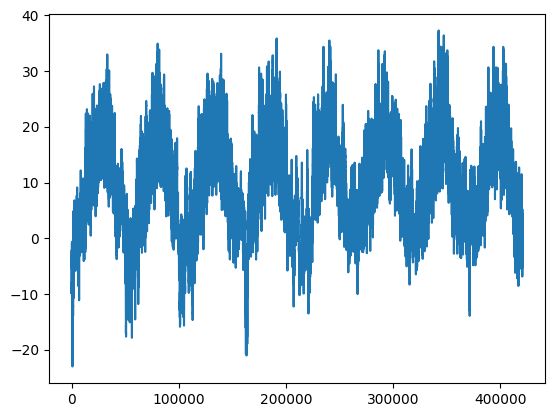

In [ ]:

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

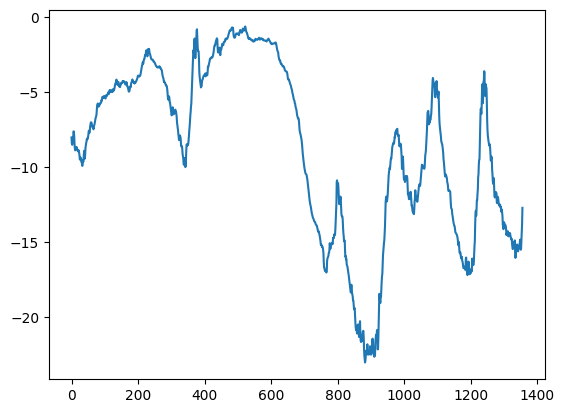

In [ ]:
plt.plot(range(1356), temperature[:1356])

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
import keras
from keras import layers


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/15
819/819 [==============================] - 424s 512ms/step - loss: 25.6053 - mae: 3.7307 - val_loss: 9.9940 - val_mae: 2.4598
Epoch 2/15
819/819 [==============================] - 430s 525ms/step - loss: 14.0533 - mae: 2.9035 - val_loss: 9.0268 - val_mae: 2.3269
Epoch 3/15
819/819 [==============================] - 350s 426ms/step - loss: 13.1620 - mae: 2.8153 - val_loss: 8.8732 - val_mae: 2.3082
Epoch 4/15
819/819 [==============================] - 392s 479ms/step - loss: 12.6352 - mae: 2.7536 - val_loss: 9.0377 - val_mae: 2.3357
Epoch 5/15
819/819 [==============================] - 389s 474ms/step - loss: 12.1224 - mae: 2.7004 - val_loss: 9.1149 - val_mae: 2.3434
Epoch 6/15
819/819 [==============================] - 390s 476ms/step - loss: 11.6738 - mae: 2.6508 - val_loss: 9.1215 - val_mae: 2.3449
Epoch 7/15
819/819 [==============================] - 391s 477ms/step - loss: 11.2826 - mae: 2.6068 - val_loss: 9.3053 - val_mae: 2.3663
Epoch 8/15
819/819 [=====================

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 gru_2 (GRU)                 (None, 120, 32)           4608      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10977 (42.88 KB)
Trainable params: 10977 (42.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


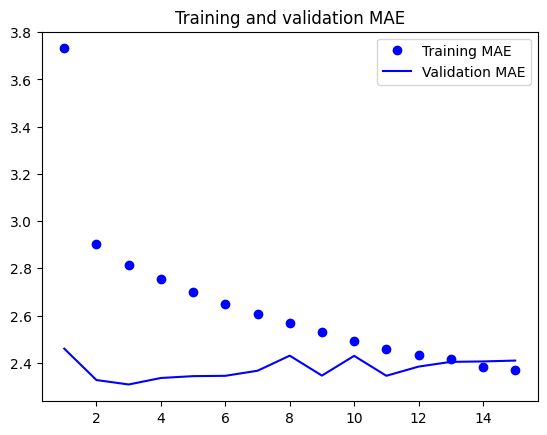

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 58s 136ms/step - loss: 9.8269 - mae: 2.4540
Test MAE: 2.45


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=12,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/12
819/819 [==============================] - 408s 490ms/step - loss: 26.2144 - mae: 3.7721 - val_loss: 9.3886 - val_mae: 2.3692
Epoch 2/12
819/819 [==============================] - 390s 476ms/step - loss: 14.0768 - mae: 2.9062 - val_loss: 9.9173 - val_mae: 2.4660
Epoch 3/12
819/819 [==============================] - 394s 480ms/step - loss: 13.2664 - mae: 2.8230 - val_loss: 9.1357 - val_mae: 2.3417
Epoch 4/12
819/819 [==============================] - 371s 453ms/step - loss: 12.6449 - mae: 2.7584 - val_loss: 8.6929 - val_mae: 2.2892
Epoch 5/12
819/819 [==============================] - 368s 449ms/step - loss: 12.1608 - mae: 2.7095 - val_loss: 8.8953 - val_mae: 2.3129
Epoch 6/12
819/819 [==============================] - 397s 484ms/step - loss: 11.7411 - mae: 2.6606 - val_loss: 8.7522 - val_mae: 2.2934
Epoch 7/12
819/819 [==============================] - 391s 478ms/step - loss: 11.3610 - mae: 2.6175 - val_loss: 8.9374 - val_mae: 2.3319
Epoch 8/12
819/819 [=====================

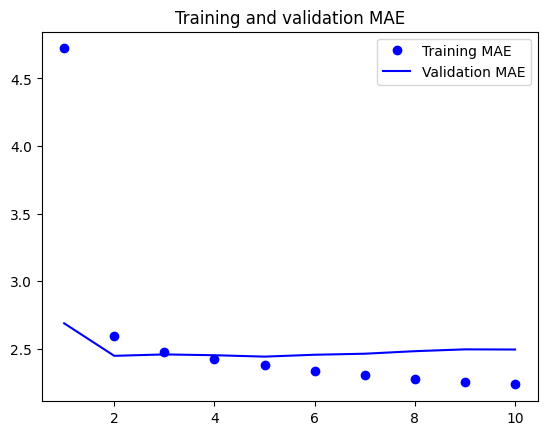

In [20]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [31]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


405/405 [==============================] - 49s 117ms/step - loss: 9.6238 - mae: 2.4267
Test MAE: 2.43


In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 135s 162ms/step - loss: 42.2236 - mae: 4.7208 - val_loss: 12.6147 - val_mae: 2.6889
Epoch 2/10
819/819 [==============================] - 122s 149ms/step - loss: 11.1167 - mae: 2.5969 - val_loss: 9.9500 - val_mae: 2.4484
Epoch 3/10
819/819 [==============================] - 125s 152ms/step - loss: 10.0431 - mae: 2.4771 - val_loss: 10.0406 - val_mae: 2.4588
Epoch 4/10
819/819 [==============================] - 125s 152ms/step - loss: 9.6428 - mae: 2.4239 - val_loss: 10.0231 - val_mae: 2.4529
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 9.3506 - mae: 2.3835 - val_loss: 9.9082 - val_mae: 2.4426
Epoch 6/10
819/819 [==============================] - 107s 130ms/step - loss: 8.9929 - mae: 2.3394 - val_loss: 9.9654 - val_mae: 2.4564
Epoch 7/10
819/819 [==============================] - 120s 146ms/step - loss: 8.7444 - mae: 2.3088 - val_loss: 10.0098 - val_mae: 2.4640
Epoch 8/10
819/819 [=====================

In [22]:
model.evaluate(test_dataset)

405/405 [==============================] - 40s 98ms/step - loss: 10.9761 - mae: 2.6015


[10.976113319396973, 2.6014609336853027]

In [23]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


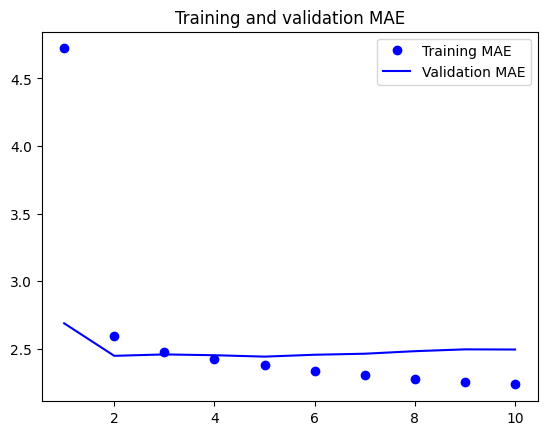

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
model.evaluate(test_dataset)

Epoch 1/10
819/819 [==============================] - 89s 107ms/step - loss: 22.3020 - mae: 3.7122 - val_loss: 15.7571 - val_mae: 3.1306
Epoch 2/10
819/819 [==============================] - 84s 102ms/step - loss: 15.6251 - mae: 3.1391 - val_loss: 17.2376 - val_mae: 3.2962
Epoch 3/10
819/819 [==============================] - 84s 102ms/step - loss: 14.1910 - mae: 2.9875 - val_loss: 14.0966 - val_mae: 2.9580
Epoch 4/10
819/819 [==============================] - 79s 96ms/step - loss: 13.3656 - mae: 2.8957 - val_loss: 14.4072 - val_mae: 2.9949
Epoch 5/10
819/819 [==============================] - 79s 97ms/step - loss: 12.7696 - mae: 2.8268 - val_loss: 14.5965 - val_mae: 3.0376
Epoch 6/10
819/819 [==============================] - 82s 100ms/step - loss: 12.2956 - mae: 2.7722 - val_loss: 14.4835 - val_mae: 3.0024
Epoch 7/10
819/819 [==============================] - 84s 103ms/step - loss: 11.9059 - mae: 2.7270 - val_loss: 13.6424 - val_mae: 2.9029
Epoch 8/10
819/819 [=======================

[17.782123565673828, 3.313836097717285]

In [26]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

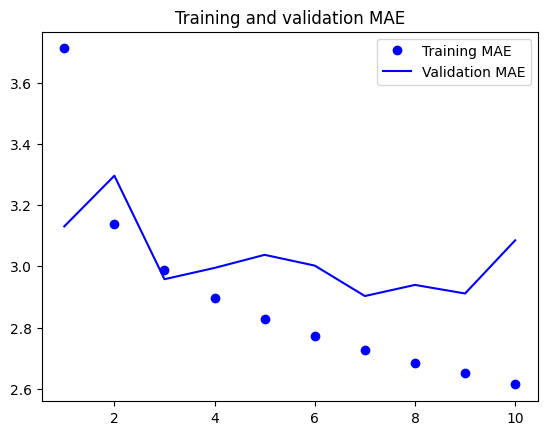

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()